## EWORX Exercise 2

### "Topic Modeling"


This is an **unsupervised learning** problem, and I have to generate **topics** because the data we got is unlabeled (or uncategorized). Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. There are severals ways to face a problem like that but I do prefer to use Latent Dirichlet Allocation (LDA) algorithm which is a statistical model. Another way to solve such problems is k-means algorithm, but it's a distance measure algorithm. On the other hand, LDA's based on the bag-of-words representation of documents.
LDA can give more realistic results than k-means for topic assignment.

What LDA exactly does?

Basic Intuition:
LDA’s approach to topic modeling is it assumes documents are produced from a mixture (collection) of topics. Each topic is a collection of (key)words. Once we provide the LDA algorithm with the number of topics, those topics then generate words (a collection of dominant words that are typical representatives) based on their probability distribution.

Considering the aforementioned, the path I did follow to solve this project is that below:

Contents:
- load xml file
- pipeline for text cleaning
- explorarory data analysis and plots
- build model
- parameters
- visualize topics
- evaluation
- verification

The "data.source.rss-feeds" is an xml file that contains articles from http://skillspanorama.cedefop.europa.eu/. I need to parse the file to extract the tags are most useful to understand my dataset like title, text (description), dates and authors.

In [1]:
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load xml file
file = open('data.source.rss-feeds.xml', encoding = 'utf-8').read()

soup = BeautifulSoup(file, 'lxml')
items = soup.find_all('item')

titles = []
texts = []
dates = []
creators = []

for item in items:
    titles.append(item.title.get_text())
    texts.append(item.description.get_text())
    dates.append(item.pubdate.get_text()[:-6]) # end before 6 last characters
    creators.append(item.find('dc:creator').get_text())
   

In [3]:
print(' title: {}\n text: {}\n date: {}\n author: {}'.format(titles[0], texts[0][:300], dates[0], creators[0]))

 title: Cedefop: The future of VET is now
 text: <div class="field field-name-title-field field-type-text field-label-hidden"><div class="field-items"><div class="field-item even">Cedefop: The future of VET is now</div></div></div><div class="field field-name-field-date field-type-datetime field-label-hidden"><div class="field-items"><div class="f
 date: Tue, 31 Oct 2017 11:12:01
 author: Anonymous


Text needs definetelly HTML tag removing and then needs further cleaning. Next step is that one! I am using **spaCy**, because it's pretty accurate and speedy in NLP tasks like this. 

So the pipeline flows like this...

- First I'm **removing HTML tags** and any tags or un-decoded unicodes left like \xa0 and 'next line' ...
- **Remove Date** from the first line. There is a date that is 'stuck' between words in the first line. That date it's not necessary to exist in text and does not add any value to the desirable output
- **Remove urls**: There are a lot of urls in texts. I do not totally removing them, but I replace any url with 'URL' string. SpaCy has a 'like_url' utility to find urls in text. Another way to extract urls is with Regular Expressions with that pattern : r'(https?://[a-zA-Z0-9./]+|(_|\?|\=|%|&)[a-zA-Z0-9./]+)|(www.[a-zA-Z0-9./]+)'. This time I'm chosing spacy to get my job done!
- **Lemmatization**: A popular technique to reduce the size of Bag-Of-Words (BOW)."lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning." . I do not need words like 'loved' and 'love' into my vocabulary because sparsity is increasing. I need the lemma of every word to reduce the size of my matrix. Thus, 'loved' turns into 'love'...
- **Remove Stop Words**: most frequent words in a sentence are stop words. I have to always think sparsity and dimensionallity in BOW. Extra info is that there are words with more than 30 characters. Those words are not real but are a sequence of words without whitespace like austriabelgiumunitedkingdomspain... and so on. Those words are gone.

In [4]:
import spacy
import en_core_web_sm as en
from spacy.lang.en.stop_words import STOP_WORDS
nlp = en.load()
from string import punctuation

In [5]:
# remove HTML tags, unicode 'leftos' and 'next line'
def remove_HTML(text):
    txt = BeautifulSoup(text, 'lxml')
    txt = txt.get_text().replace(u'\xa0', u' ')
    txt = txt.replace(u'\n', u' ')
    return(txt.strip())

# remove date from the first line
# There is a date that is 'stuck' between words in the first line.
# That date it's not necessary to exist in text and does not add any value to the desirable output
def remove_Date(text):
    pat = r"(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)(?:,\s?\w*\s[0-9]+,\s)(2015|2016|2017)"
    text = re.sub(pat, ' ', text, re.IGNORECASE)
    return(text.strip())

# URLS
def replaceURL(url):
    text = str(url).replace(str(url), 'URL') # change spacy.Token to str and replace value
    return(text)

def remove_urls(text):
    text = nlp(text) # returns spacy.Token objects / '.replace()' takes str as input.
    text = ' '.join([replaceURL(t) if t.like_url == True else t.lower_ for t in text])
    return(text)

# Lemmatization
def lemma(text):
    text = nlp(text)
    text = [t.lemma_.lower().strip() if t.lemma_ != '-PRON-' else t.lower_ for t in text]
    return(text)
    
def stopWords(text):
    text = [t for t in text if t not in set(list(STOP_WORDS)+list(punctuation) 
            + [ "–", "--", "---", "———", "———.", "...", "“", "”", "‘", "’", "'"])]
    # remove words with  3 =< #chars <=30
    text = ' '.join([t for t in text if len(t)>=3 and len(t)<=30])
    return(text)

In [6]:
# bind above functions
def Text_Normalizer(text, HTML = True, Date = True,urls = True,
                    symbols = True, lemmatizaton = True,
                    stop_words = True, white_spaces = True):
    
    if HTML:
        text = remove_HTML(text) # some texts need remove_HTML twice
    
    if Date:
        text = remove_Date(text)
    
    if urls:
        text = remove_urls(text)
        
    if symbols:
        text = re.sub(r"[^a-zA-Z]", ' ', text) # remove any non-letter character
    
    if lemmatizaton:
        text = lemma(text)
    
    if stop_words:
        text = stopWords(text)
    
    # remove any extra white space is left
    if white_spaces:
        text = re.sub(' +', ' ', text)
    
    return(text.strip().split())

** ! Info !** : I decided to remove any numerical character, because I think that dates, percentages etc. does not affect model's score! A topic needs tags-keywords and not numbers!

In [7]:
print('example 1\n',remove_HTML(texts[0])[:300])
print()
print('example 2\n',remove_HTML(texts[1599])[-300:])

example 1
 Cedefop: The future of VET is nowTuesday, October 31, 2017The 26th annual international conference of the European Forum for Vocational Education and Training (EfVET), which was held in Thessaloniki from 25 to 28 October, focused on ‘aligning work and education to the future’.        The 26th annual

example 2
 on=8.83&occupation=9.91&occupation=9.92&occupation=9.93&occupation=9.94&occupation=9.95&occupation=9.96&skill=&orderby=number&orderdir=descTitle Suffix: across sectorsTitle Suffix2: (2011-2015 comparison)Title Suffix3: (2011-2015 comparison)Title Suffix4: (2011-2015 comparison)Do not show in search:


In [8]:
# drop texts that cannot be parsed
texts = [ind for i,ind in enumerate(texts) if i not in [1599, 1600, 1601, 1605, 1609]]
titles = [ind for i,ind in enumerate(titles) if i not in [1599, 1600, 1601, 1605, 1609]]
dates = [ind for i,ind in enumerate(dates) if i not in [1599, 1600, 1601, 1605, 1609]]
creators = [ind for i,ind in enumerate(creators) if i not in [1599, 1600, 1601, 1605, 1609]]


#### Title usually contains keywords. I need these keywords in my corpus, so I merge them with the main text

In [9]:
# merge title & text
mixed = [(titles[i]+texts[i]) for i in range(len(titles))]

In [10]:
# clean texts and store them in a list
from tqdm import tqdm
clean = [Text_Normalizer(remove_HTML(text)) for text in tqdm(mixed)]

100%|██████████| 1657/1657 [14:43<00:00,  1.87it/s]


In [11]:
# save the corpus as a txt file
#import pickle 
#with open("clean_texts.txt", "wb") as fp:
#    pickle.dump(clean, fp)

In [12]:
# check the length in terms of words after cleaning.
lens = [len(txt) for txt in clean]

In [13]:
import numpy as np
print('average length: ', np.mean(lens))
print('minimum length: ', np.min(lens))
print('maximum length: ', np.max(lens))

average length:  178.86481593240796
minimum length:  1
maximum length:  3034


Wow, an article has 3000 words after cleaning!

In [14]:
for i,j in enumerate(lens):
    if j==3034:
        print(remove_HTML(texts[i])[:1000])

Skills anticipation in Finland In Finland skills anticipation activities are well-established and linked to policymaking. Over recent years, socioeconomic factors such as the effects of the economic recession, the gradually decreasing number of people in the labour force, and the ageing population increased the need for better matching between the skills supply and demand. As a result, significant investment in skills anticipation has been undertaken. The aim is to steer the education system – both vocational education and training (VET) and higher education (HE) – to meet the needs of the labour market. This is being achieved by making skills anticipation more comprehensive, with input and feedback from the government (central, regional and local) and increasingly also from stakeholders including employers, trade unions, and labour market intermediaries as well as education institutions and their staff and students. Skills anticipation takes into account sectoral, occupational and geo

#### Time to extract some **bigrams** (n-gram = 2). 

According to wikipedia: *A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words.The frequency distribution of every bigram in a string is commonly used for simple statistical analysis of text in many applications.*

I need bigrams in my model because bag-of-words do not take into account the semantics, but only the counts. So if I parse 'New York' all I got is 'new', 'york'. With bigrams I can keep together those words and my model understands that 'new_york' refers to city of NY. 

In [15]:
# import gensim. The main tool to build LDA models, bigrams, coherene score etc.
import gensim
from gensim import models, corpora

In [16]:
# take into account some bigrams
# reject bigrams with count less than 60 and bigrams with score less than 100
bigram = models.phrases.Phraser(models.phrases.Phrases(clean, min_count = 60, threshold = 100))
bigram.phrasegrams

{(b'analytical', b'highlight'): (116, 221.5206190616123),
 (b'attachmentsize', b'eusp'): (68, 217.96053297352),
 (b'columntitle', b'preffix'): (91, 236.17488091307834),
 (b'czech', b'republic'): (97, 296.46984126984125),
 (b'euro', b'area'): (333, 182.68155758077876),
 (b'human', b'resource'): (109, 128.29460580912863),
 (b'lifelong', b'learning'): (108, 109.19205745669625),
 (b'link', b'attachmentsize'): (74, 100.58281444582815),
 (b'long', b'term'): (285, 168.11100832562443),
 (b'member', b'state'): (636, 133.7953081995784),
 (b'non', b'formal'): (96, 111.0213058419244),
 (b'percentage', b'point'): (312, 266.77068260459265),
 (b'percentagegraph', b'value'): (152, 230.66542497050975),
 (b'problem', b'solve'): (116, 213.09813898704357),
 (b'skillsnet', b'bulletin'): (112, 417.90407960199),
 (b'text', b'analytical'): (75, 157.17695900363262),
 (b'type', b'percentagegraph'): (156, 148.59008853627688),
 (b'united', b'kingdom'): (69, 130.97513513513513),
 (b'upper', b'secondary'): (91, 179

In [17]:
clean_bigram = [bigram[text] for text in clean]

At this point we got clean texts, splitted into tokens, and I can move forward with some further analysis. Let's start with authors and see what's going on. After that extract some info from dates and finally find most common words that occur in articles and visualize them with a Word Cloud.

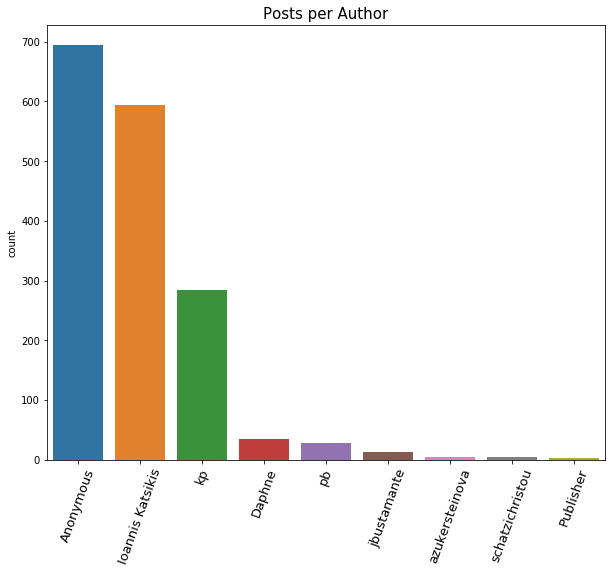

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Creators
plt.figure(figsize=(10,8))
sns.countplot(creators, order = [Counter(creators).most_common()[i][0] for i in range(len(set(creators)))])
plt.xticks(rotation = 70, fontsize = 13)
plt.title('Posts per Author', fontsize = 15)
plt.show()

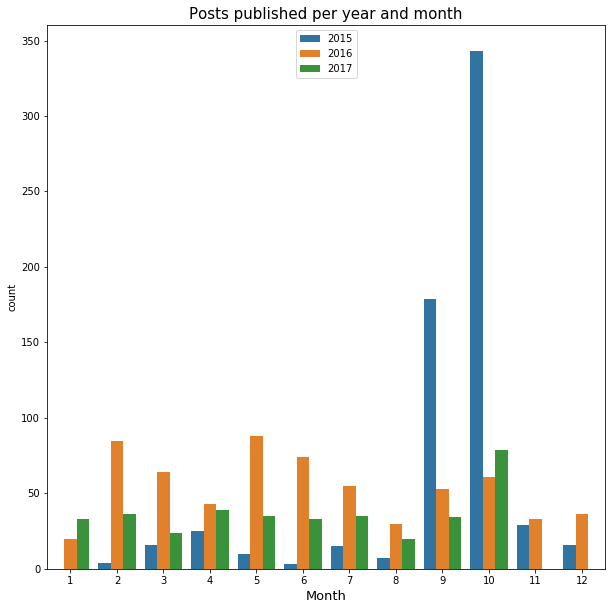

--> last post: 2017-10-31 11:12:01 
--> first post: 2015-02-23 07:50:03


In [19]:
# Dates
import pandas as pd
# convert string to timestamp
dates = pd.to_datetime(dates)

months = [dates[i].month for i in range(len(dates))]
Counter(months).most_common()

years = [dates[i].year for i in range(len(dates))]
Counter(years).most_common()

plt.figure(figsize=(10,10))
sns.countplot(months, hue = years)
plt.xlabel('Month', fontsize=13)
plt.title('Posts published per year and month', fontsize = 15)
plt.show()

print('--> last post: {}'.format(dates[0]), '\n--> first post: {}'.format(dates[-1]))

Most productive period is October 2015 and the year with the biggest average of published posts is 2016. 'Traffic' is lower at summer and especially August! 

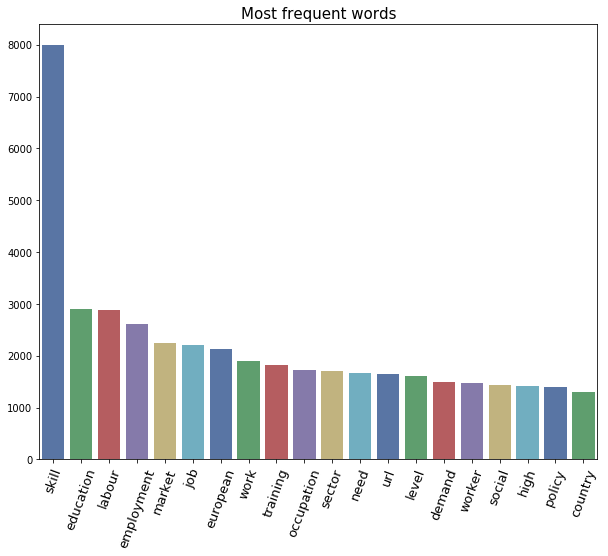

In [20]:
# flat list is a single list and not a list of lists
flat_list = [token for text in clean for token in text]
Counter(flat_list).most_common()[:20]

# barplot with top 20 words
plt.figure(figsize=(10,8))
sns.barplot([Counter(flat_list).most_common()[:20][i][0] for i in range(20)],
            [Counter(flat_list).most_common()[:20][i][1] for i in range(20)], palette = 'deep')
plt.xticks(rotation = 70, fontsize = 13)
plt.title('Most frequent words', fontsize = 15)
plt.show()

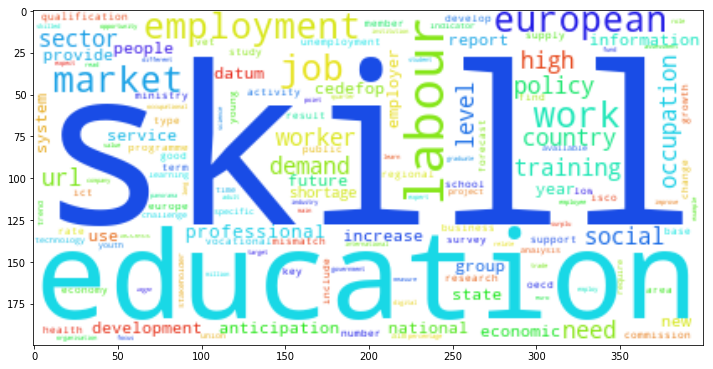

In [21]:
# Wordcloud
wordcloud = WordCloud(background_color = 'white').generate(' '.join(flat_list))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.show()

The word 'skill' is dominant as expected. It occurs 8000 times and it's by far the most used word. Following counts are for words like education, labour and empolyment. See that there are almost 2000 url links in 1657 texts. This is more than one per post. We will see in the next lines how those words are effecting the trianing model.

Class **Topics** contains a bunch of parameters, a function for the **LDA model** that returns the model itself, the **document-term matrix** and a **dictionary** with words and their numerical index. Also, the class contains an **evaluation function** for posts that are known (texts from dataset), and a visualization function using **pyLDAvis**, an awesome tool to visulaize topics and their weighted keywords.PyLDAvis is loading in a tab of your web browser or can be used in jupyter notebook if is enabled.


Let's see some parameters:
- num_topics: is obviously the number of topics that I want to generate from my corpus.
- chunksize: is the amount of data that the algorithm takes as input.
- passes: controls how often we train the model on the entire corpus.
- iterations: controls how often we repeat a particular loop over each document.
- eval_every: evaluates model's perplexity. eval_every 1 document makes the training slow but results are better.
- If 'filter words' is 'ON' then we do not take into account words that exist in less than 'no_below' of documents), and keep tokens which are contained in no more than 'no_above' document.
- alpha and eta

In [22]:
class Topics():
    
    def __init__(self, corpus, num_topics, chunksize, passes,
                 iterations, eval_every, filter_words, no_below, no_above, random_state = 142):
        self.corpus = corpus
        self.num_topics = num_topics
        self.chunksize = chunksize
        self.passes = passes
        self.iterations = iterations,
        self.eval_every = eval_every
        self.filter_words = filter_words
        self.no_below= no_below
        self.no_above = no_above
        self.random_state = random_state
           
    def model_LDA(self):
        # build dictionary from corpus
        dictionary = corpora.Dictionary(self.corpus)
        # filter words if param is 'ON'
        if self.filter_words:
                dictionary.filter_extremes(no_below = self.no_below, no_above = self.no_above)
    
        print('size of unique tokens vocabulary: {}'.format(len(list(dictionary))))
        # matrix of documents-temrs / Document to Bag-Of-Words
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in self.corpus]
        
        # initialize model
        LDA = models.ldamodel.LdaModel
        
        model = LDA(doc_term_matrix, num_topics = self.num_topics, id2word = dictionary,\
                    alpha='auto', eta='auto',\
                    chunksize = self.chunksize, passes = self.passes,\
                    eval_every = self.eval_every,
                    random_state = self.random_state)
        
        return(model, doc_term_matrix, dictionary)

    # evaluate the score of topics for known texts
    # model and index of text are needed
    def evaluate_model(self, model, txt_idx):
        for idx, score in sorted(model[0][model[1][txt_idx]], key = lambda scr: (-1)*scr[1]):
            print("\nScore: {}\t \nTopic: {} \n{}".format(score, idx+1, model[0].print_topic(idx, 10)))

    # use pyLDAvis to plot topics
    def plot_model(self, model):
        model_display = pyLDAvis.gensim.prepare(model[0], model[1], model[2], sort_topics = False)
        return(pyLDAvis.show(model_display))


#### I am not going to use a single model but I want to grid search over parameters to find an optimal model for my data!

In [28]:
new_results = {}
for num_topics in range(3,13,1):
    new_params = [[clean_bigram, num_topics, len(clean), 50, 400, None, False, 20, 0.5],
                  [clean_bigram, num_topics, len(clean), 50, 400, 1, False, 20, 0.5],
                  [clean_bigram, num_topics, len(clean), 50, 400, None, True, 20, 0.5],
                  [clean_bigram, num_topics, len(clean), 50, 400, 1, True, 20, 0.5],       
                  [clean_bigram, num_topics, len(clean), 50, 400, None, True, 30, 0.5],    
                  [clean_bigram, num_topics, len(clean), 50, 400, 1, True, 30, 0.5],
                  [clean_bigram, num_topics, len(clean), 50, 400, 1, False, 30, 0.5]
                 ]

    param_ = 1
    for lda, mdl, param in zip(['lda'+str(i+1) for i in range(len(new_params))],
                               ['model'+str(i+1) for i in range(len(new_params))],
                               new_params):
        print('set of params ', param_, 'number of topics: ', num_topics)
        lda = Topics(*param)
        mdl = lda.model_LDA()
        new_results[lda] = [mdl]
        param_ += 1


set of params  1 number of topics:  3
size of unique tokens vocabulary: 15582
set of params  2 number of topics:  3
size of unique tokens vocabulary: 15582
set of params  3 number of topics:  3
size of unique tokens vocabulary: 1393
set of params  4 number of topics:  3
size of unique tokens vocabulary: 1393
set of params  5 number of topics:  3
size of unique tokens vocabulary: 1060
set of params  6 number of topics:  3
size of unique tokens vocabulary: 1060
set of params  7 number of topics:  3
size of unique tokens vocabulary: 15582
set of params  1 number of topics:  4
size of unique tokens vocabulary: 15582
set of params  2 number of topics:  4
size of unique tokens vocabulary: 15582
set of params  3 number of topics:  4
size of unique tokens vocabulary: 1393
set of params  4 number of topics:  4
size of unique tokens vocabulary: 1393
set of params  5 number of topics:  4
size of unique tokens vocabulary: 1060
set of params  6 number of topics:  4
size of unique tokens vocabulary:

**Coherence value** (or score) is a measurement that is used to evaluate an LDA model. To be more clear Topic Coherence defines if the number of topics that were given to the algorithm is the "right" one. The bigger the coherence value, the better the model with its number of topics. Another way to measure model's performance is perplexity, but is kinda poor comparing to coherence metric. Topic modelling algorithms used to be tested on their human interpretability by presenting them to humans and taking their input on them. So, in our case imagine that we give a bunch of posts to several humans and they try to categorize them, having the aknowledgement of number of topics. This evaluation has 4 stages:
- Segmentation: Where topics are partitioned into several documents assuming that the quality of topics in each document is different.
- Probability Estimation : Where the quantity of topics in each document is measured.
- Confirmation Measure : Where the quality of topics (according to a certain metric) in each document is measured, and a number is assigned to each document with respect to its quantity.
- Aggregation : The meter where these quality numbers are combined in a certain way (eg. arithmetic mean) to come up with one number.

In [31]:
def compute_coherence_values(model, dictionary, corpus, texts):
    coherencemodel = models.CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence='c_v')
    return(coherencemodel.get_coherence())

In [37]:
# compute coherence value for every possible number of topics and nested parameters
ind = 1
for k, v in new_results.items():
    print(ind,'number of topics: {}'.format(v[0][0].num_topics),\
          'parameters: {}'.format(v[0][0].eval_every),\
          compute_coherence_values(v[0][0], v[0][2], v[0][2], clean_bigram))
    ind +=1

1 number of topics: 3 parameters: None 0.3438785364690766
2 number of topics: 3 parameters: 1 0.3443172941974519
3 number of topics: 3 parameters: None 0.3584023737324444
4 number of topics: 3 parameters: 1 0.3584023737324444
5 number of topics: 3 parameters: None 0.35852815744271327
6 number of topics: 3 parameters: 1 0.3695155972171693
7 number of topics: 3 parameters: 1 0.3443172941974519
8 number of topics: 4 parameters: None 0.3440607647820355
9 number of topics: 4 parameters: 1 0.35420440278863397
10 number of topics: 4 parameters: None 0.360718076847271
11 number of topics: 4 parameters: 1 0.35465663294527816
12 number of topics: 4 parameters: None 0.3738503869536522
13 number of topics: 4 parameters: 1 0.3738503869536522
14 number of topics: 4 parameters: 1 0.35420440278863397
15 number of topics: 5 parameters: None 0.3743492723210665
16 number of topics: 5 parameters: 1 0.3801273408537316
17 number of topics: 5 parameters: None 0.33616832093767035
18 number of topics: 5 parame

The highest score is 0.4282 for **7 topics** and parameters:
- passes = 50
- iterations = 400
- evaluate every = 1
- filter extreme words: True 
- no_below = 30
- no_above = 0.5

Below let's build the model we will use for evaluation and topic visualization.

In [38]:
LDA = Topics(clean_bigram, 7, len(clean_bigram), 50, 400, 1, True, 30, 0.5)
Model = LDA.model_LDA()

# model.save('model_filter.gensim')

size of unique tokens vocabulary: 1060


The model we finally chose has 1060 words in its dictionary, considering the initial size of 15K words. The training process has to do with the number of topics, the evaluation step, the size of the doc-term matrix and the size of the dictionary. If our dictionary was quite large (i.e. 20000), then we could have the choice of keeping the top 5000 words for example. All these parameters affect the speed of training, but once the model is trained we can load it to categorize documents into topics.

Below, coming up the evaluation of the Model with a known text, to check the output of it.

In [40]:
# check topics for the 999th text of corpus
LDA.evaluate_model(Model, 999)


Score: 0.9193661212921143	 
Topic: 1 
0.024*"employment" + 0.023*"social" + 0.021*"work" + 0.019*"labour" + 0.017*"european" + 0.014*"market" + 0.014*"economic" + 0.012*"report" + 0.011*"policy" + 0.011*"job"

Score: 0.07186410576105118	 
Topic: 7 
0.060*"indicator" + 0.053*"skill" + 0.046*"type" + 0.039*"year" + 0.032*"education" + 0.026*"countriesgraph" + 0.026*"value_type" + 0.026*"age" + 0.025*"level" + 0.023*"preffix"


As we can see the Model says that text [999] belongs to Topic 1 and the probability of that happen is 0.92. Ten (10) of the most weighted words that characterize this topic are 'indicator', 'skill', 'education', 'age' etc.

In [44]:
# visualize topics with pyLDAvis

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

LDA.plot_model(Model)

/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Looks like we have overlapping in 4 out of 7 topics. The size of the 'bubble' defines Topic's "strength". If we let the mouse upon the bubble, on the right side we got the frequency of each term in the document compared to the frequency of that term in the corpus.

#### Why overlapping?
To be honest, although we had the higher coherence value for 7 topics , I was sure that the size of the corpus and the content homogeneity in a lot of texts would lead to that phenomenon. However coherence value 0.42 is not that satisfying. Is something totally wrong? I guess not. But I'll let conclusions for the end...

In [46]:
# top words in every topic and a calculated perplexity
top_topics = Model[0].top_topics(Model[1])
top_topics

[([(0.022097962, 'skill'),
   (0.02178015, 'occupation'),
   (0.018125376, 'professional'),
   (0.016862633, 'sector'),
   (0.016028367, 'worker'),
   (0.013973173, 'demand'),
   (0.012801704, 'shortage'),
   (0.012029445, 'service'),
   (0.011553316, 'job'),
   (0.010920093, 'ict'),
   (0.00993278, 'high'),
   (0.0090369815, 'isco'),
   (0.008684778, 'health'),
   (0.008656176, 'increase'),
   (0.00839163, 'employment'),
   (0.007798916, 'level'),
   (0.0076337345, 'need'),
   (0.007032288, 'url'),
   (0.0068797893, 'market'),
   (0.0065418435, 'labour')],
  -0.759221050757701),
 ([(0.09574485, 'skill'),
   (0.023120748, 'cedefop'),
   (0.021628013, 'european'),
   (0.020081282, 'job'),
   (0.011303601, 'need'),
   (0.010092791, 'country'),
   (0.010034737, 'new'),
   (0.00972261, 'policy'),
   (0.009651788, 'panorama'),
   (0.009321066, 'information'),
   (0.009101054, 'datum'),
   (0.008921243, 'use'),
   (0.008643252, 'work'),
   (0.008050646, 'development'),
   (0.007925486, 'qual

In [47]:
# words that are common in 7 Topics
set([top_topics[0][0][i][1] for i in range(20)]).intersection(
        [top_topics[1][0][i][1] for i in range(20)],\
        [top_topics[2][0][i][1] for i in range(20)],\
        [top_topics[3][0][i][1] for i in range(20)])

{'market'}

#### Categorize unseen texts with Model

Text List contains 5 texts that are part of 5 different posts that were posted in 2018 at skills panorama. Some of the tags that allready exist are #Future Jobs, #Labour Market Context, #Skills anticipation in countries, #European Skills Index, #People and Skills, #Matching Skills and Jobs, #EU.

These 5 texts are going to be parsed and tokenized and then will be fed in the Model.

In [49]:
from test_texts import text_list

val = 1

for text in text_list:
    # parse and clean the unknown text
    print('text: {}'.format(val)+'/5')
    vector = Model[2].doc2bow(Text_Normalizer(*text))
    for idx, score in sorted(Model[0][vector], key = lambda scr: (-1)*scr[1]):
            print("\nScore: {}\t \nTopic: {} \n{}".format(score, idx+1, Model[0].print_topic(idx, 10)))
    print()
    val += 1

text: 1/5


/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  self.parser.feed(markup)



Score: 0.43908706307411194	 
Topic: 4 
0.022*"skill" + 0.022*"occupation" + 0.018*"professional" + 0.017*"sector" + 0.016*"worker" + 0.014*"demand" + 0.013*"shortage" + 0.012*"service" + 0.012*"job" + 0.011*"ict"

Score: 0.20817328989505768	 
Topic: 1 
0.024*"employment" + 0.023*"social" + 0.021*"work" + 0.019*"labour" + 0.017*"european" + 0.014*"market" + 0.014*"economic" + 0.012*"report" + 0.011*"policy" + 0.011*"job"

Score: 0.14421170949935913	 
Topic: 3 
0.047*"skill" + 0.024*"labour" + 0.022*"anticipation" + 0.020*"url" + 0.018*"education" + 0.017*"market" + 0.013*"national" + 0.013*"employment" + 0.012*"forecast" + 0.011*"use"

Score: 0.12788328528404236	 
Topic: 5 
0.096*"skill" + 0.023*"cedefop" + 0.022*"european" + 0.020*"job" + 0.011*"need" + 0.010*"country" + 0.010*"new" + 0.010*"policy" + 0.010*"panorama" + 0.009*"information"

Score: 0.07980379462242126	 
Topic: 2 
0.049*"rate" + 0.041*"unemployment" + 0.028*"employment" + 0.025*"quarter" + 0.024*"euro_area" + 0.023*"per

/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  self.parser.feed(markup)



Score: 0.9965539574623108	 
Topic: 3 
0.047*"skill" + 0.024*"labour" + 0.022*"anticipation" + 0.020*"url" + 0.018*"education" + 0.017*"market" + 0.013*"national" + 0.013*"employment" + 0.012*"forecast" + 0.011*"use"

text: 3/5


/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  self.parser.feed(markup)



Score: 0.6063525080680847	 
Topic: 5 
0.096*"skill" + 0.023*"cedefop" + 0.022*"european" + 0.020*"job" + 0.011*"need" + 0.010*"country" + 0.010*"new" + 0.010*"policy" + 0.010*"panorama" + 0.009*"information"

Score: 0.22002731263637543	 
Topic: 1 
0.024*"employment" + 0.023*"social" + 0.021*"work" + 0.019*"labour" + 0.017*"european" + 0.014*"market" + 0.014*"economic" + 0.012*"report" + 0.011*"policy" + 0.011*"job"

Score: 0.17084094882011414	 
Topic: 4 
0.022*"skill" + 0.022*"occupation" + 0.018*"professional" + 0.017*"sector" + 0.016*"worker" + 0.014*"demand" + 0.013*"shortage" + 0.012*"service" + 0.012*"job" + 0.011*"ict"

text: 4/5


/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  self.parser.feed(markup)



Score: 0.8267409801483154	 
Topic: 5 
0.096*"skill" + 0.023*"cedefop" + 0.022*"european" + 0.020*"job" + 0.011*"need" + 0.010*"country" + 0.010*"new" + 0.010*"policy" + 0.010*"panorama" + 0.009*"information"

Score: 0.12198781222105026	 
Topic: 1 
0.024*"employment" + 0.023*"social" + 0.021*"work" + 0.019*"labour" + 0.017*"european" + 0.014*"market" + 0.014*"economic" + 0.012*"report" + 0.011*"policy" + 0.011*"job"

Score: 0.049773845821619034	 
Topic: 4 
0.022*"skill" + 0.022*"occupation" + 0.018*"professional" + 0.017*"sector" + 0.016*"worker" + 0.014*"demand" + 0.013*"shortage" + 0.012*"service" + 0.012*"job" + 0.011*"ict"

text: 5/5


/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  self.parser.feed(markup)



Score: 0.6115666031837463	 
Topic: 4 
0.022*"skill" + 0.022*"occupation" + 0.018*"professional" + 0.017*"sector" + 0.016*"worker" + 0.014*"demand" + 0.013*"shortage" + 0.012*"service" + 0.012*"job" + 0.011*"ict"

Score: 0.23721826076507568	 
Topic: 5 
0.096*"skill" + 0.023*"cedefop" + 0.022*"european" + 0.020*"job" + 0.011*"need" + 0.010*"country" + 0.010*"new" + 0.010*"policy" + 0.010*"panorama" + 0.009*"information"

Score: 0.1489892303943634	 
Topic: 1 
0.024*"employment" + 0.023*"social" + 0.021*"work" + 0.019*"labour" + 0.017*"european" + 0.014*"market" + 0.014*"economic" + 0.012*"report" + 0.011*"policy" + 0.011*"job"



There is ambiguity for text 1, it's not clear in which topic belongs (as a result of overlapping). Text 2 has the label Topic 1, text 3 is slightly categorized as Topic 5. Finally the probability of text 4 to belong in Topic 5 is 0.82 and the last text (5) tends to be a Topic 4 post. Consider that texts 3 and 4 have exactly the same tags and both categorized in Topic 5!

### Summary and Conclusion

As data is loaded is parsed and the main feature we want to build our project is text. Additionally we get some interesting insights from authors and dates. I could use pandas to store data into a dataframe and manipulate it, but this time I did chose to stay with simple lists and keep my memory usage low. However, the dataset was small and pandas would not be a problem.

After texts got cleaned I wanted to build a model as robust as it can be. I searched several parameters in a loop to save time from tuning parameters manually. Also, was defined the number of topics that could probably lead to a good and reliable model. Like I mentioned before there is a bunch of (hyper)parameters than can affect the desireable output. One of them is the amount of data. Having 7 topics for 1657 texts is likely not to get satisfying results. I do believe that if we had more data the performance would be dramatically better. In that case we could reconsider the number of topics, generate more words for the vocabulary and have a bigger variance in top topics words. 

A different approach could be to use TF-IDF vectorizer to change our model from a count based model to a more weighted term frequence model. And it could be really interesting to exclude the word 'skill' from the vocabulary.